# Project Title: Rabies in Israel, a data story

## Objectives
The primary objective of this project is to evaluate the prevalence and distribution of the Rabies virus in Israel by analyzing reported cases over time. The project aims to identify trends in the appearance of Rabies across different regions and species, and to understand seasonal patterns in the data. This analysis will provide insights that could inform public health strategies and preventive measures against Rabies in Israel.

### Libreries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import polars as pl

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly as plty

# API imports
import requests

#### Get Data from data.gov.il

In [58]:
data_url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=85cd1c27-7824-45ff-9982-22da0285fafb'  
all_records = []

# Fetch the first page to get the total number of records
response = requests.get(data_url)
if response.status_code == 200:
    data = response.json()
    total_records = data['result']['total']
    all_records.extend(data['result']['records'])
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    total_records = 0

# Calculate the number of iterations needed based on the limit (100 records per request in this case)
iterations = (total_records // 100) + 1

for i in range(1, iterations):
    offset = i * 100
    response = requests.get(f"{data_url}&offset={offset}")
    if response.status_code == 200:
        data = response.json()
        all_records.extend(data['result']['records'])
    else:
        print(f"Failed to fetch data at offset {offset}. Status code: {response.status_code}")

# Convert all_records to a DataFrame
df_rabies_raw = pd.DataFrame(all_records)

In [59]:
# Save DataFrame df_rabies_raw to CSV
csv_file_path = 'data/df_rabies_raw.csv' 
df_rabies_raw.to_csv(csv_file_path, index=False)

print(f"DataFrame saved as CSV at: {csv_file_path}")

DataFrame saved as CSV at: data/df_rabies_raw.csv


In [55]:
# OPTIONAL: get data df_rabies_raw from the csv
# Define the path to the CSV file
csv_file_path = 'data/df_rabies_raw.csv'

# Load the DataFrame from the CSV file
df_rabies_raw = pd.read_csv(csv_file_path)

# Print the first few rows of the DataFrame to verify
print('-'*20 + 'HEAD' + '-'*20)
print(df_rabies_raw.head())
print('-'*20 + 'COLUMNS' + '-'*20)
print(df_rabies_raw.columns)
print('-'*20 + 'INFO' + '-'*20)
print(df_rabies_raw.info())
print('-'*20 + 'DESCRIBE' + '-'*20)
print(df_rabies_raw.describe())

--------------------HEAD--------------------
   _id  OBJECTID Animal_Lab_ID  Event        Date  \
0    1       710     A00507442   29.0  2024-05-12   
1    2       709     A00506588   28.0  2024-04-30   
2    3       706     A00506410   25.0  2024-04-29   
3    4       707     A00506411   26.0  2024-04-29   
4    5       708     A00506412   27.0  2024-04-29   

                                          LinkToTest  \
0  https://www.gov.il/BlobFolder/reports/kalevet-...   
1  https://www.gov.il/BlobFolder/reports/dalton-2...   
2  https://www.gov.il/BlobFolder/reports/menahami...   
3  https://www.gov.il/BlobFolder/reports/menahami...   
4  https://www.gov.il/BlobFolder/reports/kfar-yeh...   

                                            OpenLink  \
0  <a href="https://www.gov.il/BlobFolder/reports...   
1  <a href="https://www.gov.il/BlobFolder/reports...   
2  <a href="https://www.gov.il/BlobFolder/reports...   
3  <a href="https://www.gov.il/BlobFolder/reports...   
4  <a href="https:/

#### Data Exploration

In [60]:
print('-'*20 + 'HEAD'+'-'*20)
print(df_rabies_raw.head())
print('-'*20 + 'COLUMNS'+'-'*20)
print(df_rabies_raw.columns)
print('-'*20 + 'INFO'+'-'*20)
print(df_rabies_raw.info())
print('-'*20 + 'DESCRIBE'+'-'*20)
print(df_rabies_raw.describe())

--------------------HEAD--------------------
   _id  OBJECTID Animal_Lab_ID Event        Date  \
0    1       710     A00507442  29.0  2024-05-12   
1    2       709     A00506588  28.0  2024-04-30   
2    3       706     A00506410  25.0  2024-04-29   
3    4       707     A00506411  26.0  2024-04-29   
4    5       708     A00506412  27.0  2024-04-29   

                                          LinkToTest  \
0  https://www.gov.il/BlobFolder/reports/kalevet-...   
1  https://www.gov.il/BlobFolder/reports/dalton-2...   
2  https://www.gov.il/BlobFolder/reports/menahami...   
3  https://www.gov.il/BlobFolder/reports/menahami...   
4  https://www.gov.il/BlobFolder/reports/kfar-yeh...   

                                            OpenLink  \
0  <a href="https://www.gov.il/BlobFolder/reports...   
1  <a href="https://www.gov.il/BlobFolder/reports...   
2  <a href="https://www.gov.il/BlobFolder/reports...   
3  <a href="https://www.gov.il/BlobFolder/reports...   
4  <a href="https://www.g

### Data preprocessing plan

* OBJECTID - set as primery key
* Animal_Lab_ID - as is
* Event, Species - as is
* Date - set as pandas date format
* LinkToTest, OpenLink, LinkToMre, LinkMoreOpen - remove 
* Year - remove due to redundancy
* RegionEng, SpeciesNameEng, SettlementEng, LocationNotSettlementEng - as is
* RegionHeb, SpeciesNameHeb SettlementHeb,LocationNotSettlementHeb, x, y - remove

In [61]:
# Verify columns
print('-'*20 + 'COLUMNS' + '-'*20)
print(df_rabies_raw.columns)

# Add or refill _id as auto-incrementing integer starting from 1
df_rabies_raw['_id'] = range(1, len(df_rabies_raw) + 1)

# Check if _id exists in the DataFrame
if '_id' not in df_rabies_raw.columns:
    raise KeyError("_id column is missing from the DataFrame. Please check the data source.")

# Ensure OBJECTID is unique and has no missing values
if df_rabies_raw['_id'].is_unique and not df_rabies_raw['_id'].isnull().any():
    df_rabies_raw.set_index('_id', inplace=True)
else:
    raise ValueError("_id column cannot be used as a primary key due to duplicates or missing values.")

# Convert Date to pandas datetime format
df_rabies_raw['Date'] = pd.to_datetime(df_rabies_raw['Date'])

# Remove LinkToTest, OpenLink, LinkToMre, LinkMoreOpen, Year
df_rabies_raw.drop(['LinkToTest', 'OpenLink', 'LinkToMre', 'LinkMoreOpen', 'Year'], axis=1, inplace=True)

# Remove RegionHeb, SpeciesNameHeb, SettlementHeb, LocationNotSettlementHeb, x, y
df_rabies_raw.drop(['RegionHeb', 'SpeciesNameHeb', 'SettlementHeb', 'LocationNotSettlementHeb', 'x', 'y'], axis=1, inplace=True)

print(df_rabies_raw.describe())

# Save the cleaned DataFrame to CSV
csv_file_path = 'data/df_rabies_cleaned.csv'
df_rabies_raw.to_csv(csv_file_path, index=True)

print(f"Cleaned DataFrame saved as CSV at: {csv_file_path}")


--------------------COLUMNS--------------------
Index(['_id', 'OBJECTID', 'Animal_Lab_ID', 'Event', 'Date', 'LinkToTest',
       'OpenLink', 'LinkToMre', 'LinkMoreOpen', 'Year', 'SpeciesNameEng',
       'RegionEng', 'RegionHeb', 'SpeciesNameHeb', 'Species', 'SettlementHeb',
       'SettlementEng', 'LocationNotSettlementEng', 'LocationNotSettlementHeb',
       'x', 'y'],
      dtype='object')
          OBJECTID                           Date
count  2534.000000                           2534
mean    284.223757  2013-09-11 11:34:25.666929664
min       1.000000            2006-02-28 00:00:00
25%     167.000000            2009-11-19 00:00:00
50%     277.000000            2012-05-29 00:00:00
75%     390.000000            2017-11-02 00:00:00
max     710.000000            2024-05-12 00:00:00
std     156.651007                            NaN
Cleaned DataFrame saved as CSV at: data/df_rabies_cleaned.csv


In [62]:
print('-'*20 + 'HEAD'+'-'*20)
print(df_rabies_raw.head())
print('-'*20 + 'COLUMNS'+'-'*20)
print(df_rabies_raw.columns)
print('-'*20 + 'INFO'+'-'*20)
print(df_rabies_raw.info())
print('-'*20 + 'DESCRIBE'+'-'*20)
print(df_rabies_raw.describe())

--------------------HEAD--------------------
     OBJECTID Animal_Lab_ID Event       Date SpeciesNameEng    RegionEng  \
_id                                                                        
1         710     A00507442  29.0 2024-05-12            Dog       Amakim   
2         709     A00506588  28.0 2024-04-30         Cattle  Galil Golan   
3         706     A00506410  25.0 2024-04-29          Sheep       Amakim   
4         707     A00506411  26.0 2024-04-29          Sheep       Amakim   
5         708     A00506412  27.0 2024-04-29         Cattle       Amakim   

    Species SettlementEng LocationNotSettlementEng  
_id                                                 
1      None          None                     None  
2     VII B        Dalton                     None  
3     VII A     Menahemya                     None  
4     VII A     Menahemya                     None  
5     VII A          None                     None  
--------------------COLUMNS--------------------
Ind

In [63]:
print('-'*20 + 'Species Name'+'-'*20)
print(df_rabies_raw['SpeciesNameEng'].value_counts())
print('-'*20 + 'Region'+'-'*20)
print(df_rabies_raw['RegionEng'].value_counts())
print('-'*20 + 'Species'+'-'*20)
print(df_rabies_raw['Species'].value_counts())
print('-'*20 + 'Settlement Name'+'-'*20)
print(df_rabies_raw['SettlementEng'].value_counts())

--------------------Species Name--------------------
SpeciesNameEng
Dog         1018
Jackal       709
Cattle       417
Fox          128
Sheep         67
Wolf          64
Cat           47
Horse         29
Badger        26
Donkey        12
Martes         7
Mongoose       7
Cow            2
Name: count, dtype: int64
--------------------Region--------------------
RegionEng
Galil Golan      1419
Amakim            801
Galil Maaravi     171
Hasharon           54
Negev              48
Shfela Vahar       41
Name: count, dtype: int64
--------------------Species--------------------
Species
VII       1240
VII B      390
VII A      281
I          179
VIIA       151
V7         110
III         38
V           16
V1          10
IV           1
V II A       1
VIIB         1
Name: count, dtype: int64
--------------------Settlement Name--------------------
SettlementEng
Majdal Shams    77
Zefat           72
Gan Ner         71
Menahemya       56
Dan             55
                ..
Agur             1
Mesil

## Data Visualizations

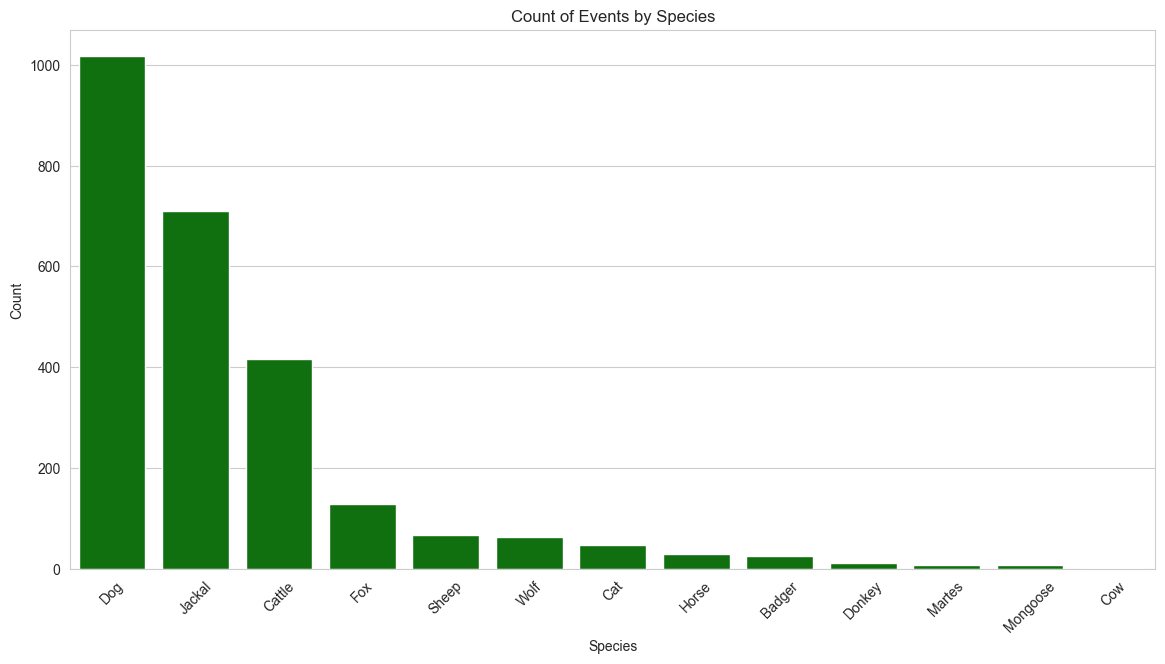

In [64]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Count Plot for SpeciesNameEng
plt.figure(figsize=(14, 7), )
sns.countplot(data=df_rabies_raw, x='SpeciesNameEng', order=df_rabies_raw['SpeciesNameEng'].value_counts().index, color='g')
plt.title('Count of Events by Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-labels if they overlap
plt.show()

The prevalence of rabies cases in dogs and jackals is higher than the rest of species, it can be attributed to several factors:

Domestication and Proximity to Humans: Dogs are the most common domestic animal and have close contact with humans. This proximity increases the likelihood of rabies transmission to dogs from wildlife and subsequently to humans. Rabies in dogs is a significant public health concern because of their close relationship with humans.

Behavioral Factors: Jackals, being wild canids, often come into contact with areas inhabited by humans, especially if they are searching for food. This can lead to interactions with domestic animals, including dogs, and potential transmission of the virus.

Vaccination Rates: In many regions, especially where rabies is endemic, dogs may not be vaccinated against rabies as consistently as required. This lack of vaccination can lead to higher rates of rabies among dogs.

Population Density and Control: Both dogs and jackals can have large populations, particularly in rural or suburban areas where control measures may be less stringent. High population densities can facilitate the spread of the virus.

Natural Reservoirs: Jackals are natural reservoirs of rabies in the wild and can maintain the virus within their populations. They can transmit the virus to other animals, including dogs, through bites.

Ecological Factors: The habitats of jackals may overlap with those of other rabies reservoir species, such as foxes and bats, increasing the likelihood of cross-species transmission.

Survival and Shedding of the Virus: Both dogs and jackals may shed the rabies virus for extended periods before showing symptoms, which allows for greater transmission potential.

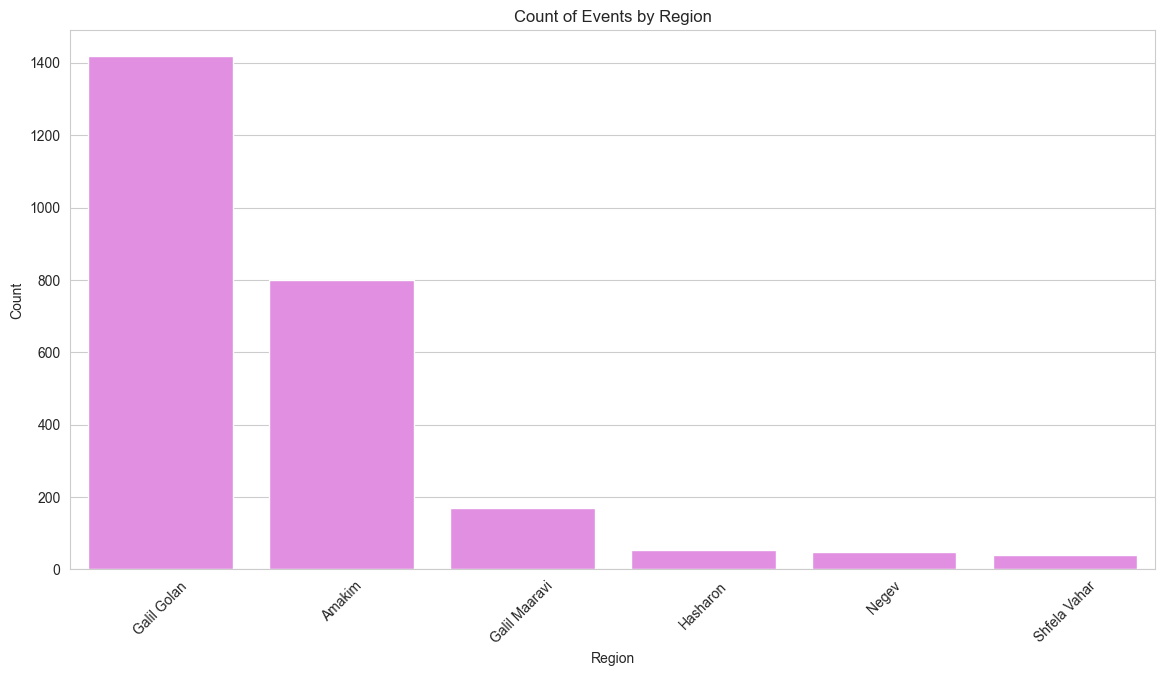

In [65]:
# Count Plot for RegionEng
plt.figure(figsize=(14, 7))
sns.countplot(data=df_rabies_raw, x='RegionEng', order=df_rabies_raw['RegionEng'].value_counts().index, color='violet')
plt.title('Count of Events by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-labels if they overlap
plt.show()

From the Count Plot for Region it is seen that most cases are found at the Galil and Golan regions.

The Galil and Golan regions, known for their diverse wildlife and rural landscapes, may exhibit higher cases of rabies for several reasons:

Wildlife Reservoirs: These areas are habitats for wildlife species known to be common reservoirs for the rabies virus, such as foxes, jackals, and raccoons. The interaction between wild animals and domestic pets or livestock can lead to a higher incidence of rabies transmission.

Rural and Agricultural Land: The Galil and Golan regions have substantial agricultural activity. Farms and domestic animals may have greater exposure to wildlife, increasing the risk of rabies transmission.

Human-Wildlife Interaction: Increased human encroachment into wildlife habitats can lead to more frequent interactions between humans and potentially rabid animals, raising the risk of rabies cases.

Vaccination and Control Measures: There may be variations in the effectiveness of animal vaccination programs and wildlife rabies control measures. Regions with less stringent control measures might experience more outbreaks.

Climate and Environment: Environmental factors, such as climate, vegetation, and the availability of water sources, can influence the density and behavior of rabies vector species. Cooler climates in higher altitudes, like the Golan Heights, might affect the survival and transmission patterns of the rabies virus.

Reporting and Surveillance: The observed higher number of cases could also be a result of more thorough reporting and surveillance in these regions, rather than an actual higher incidence of the disease.

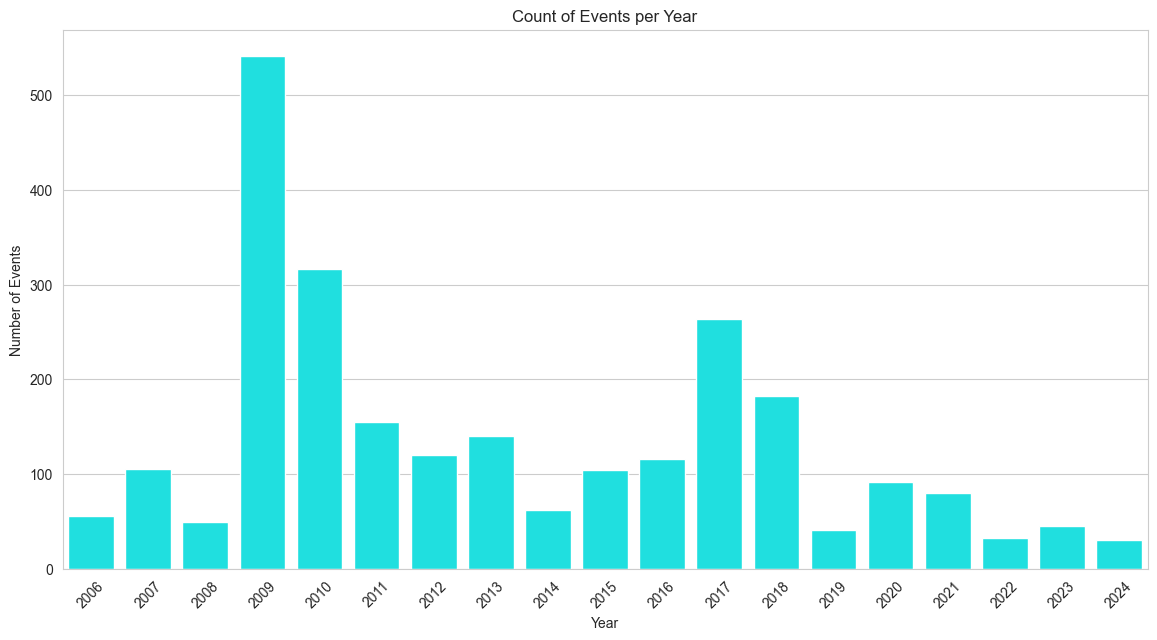

In [66]:
# Extract year from Date
df_rabies_raw['Year'] = df_rabies_raw['Date'].dt.year

# Count the number of events per year
events_per_year = df_rabies_raw.groupby('Year').size()

# Now plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x=events_per_year.index, y=events_per_year.values, color='aqua')
plt.title('Count of Events per Year')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)  # Rotate x-labels if they overlap
plt.show()

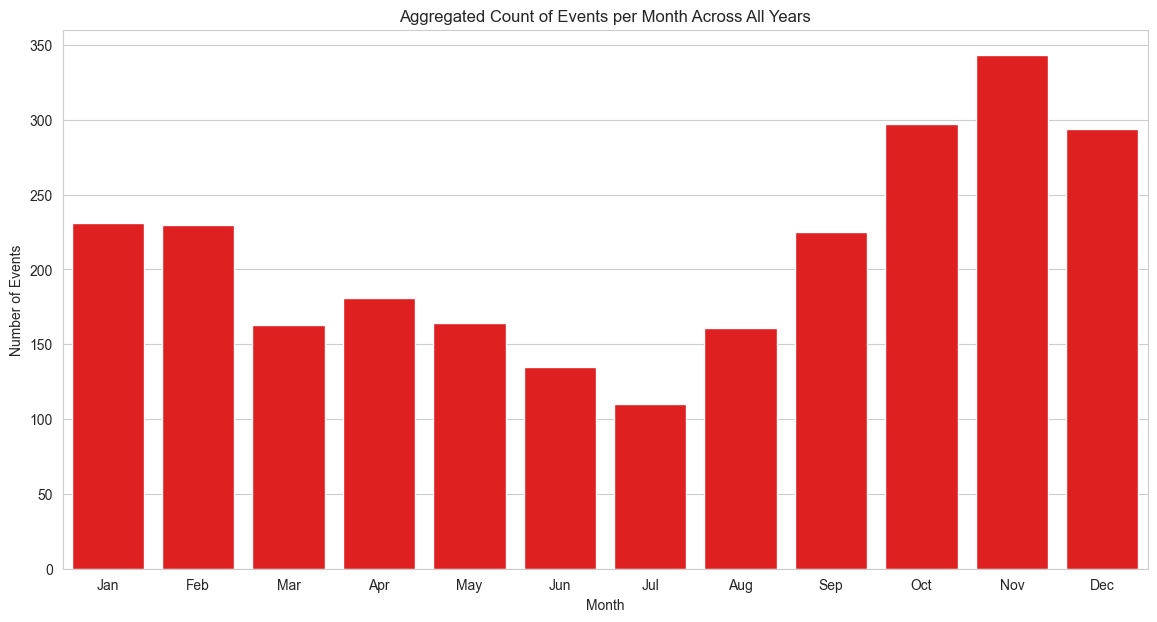

In [67]:
# Aggregated Count by Month Across All Years

# Extract month from Date
df_rabies_raw['Month'] = df_rabies_raw['Date'].dt.month

# Count the number of events per month
events_per_month = df_rabies_raw.groupby('Month').size()

# Now plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x=events_per_month.index, y=events_per_month.values, color='red')
plt.title('Aggregated Count of Events per Month Across All Years')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

According to the count by Month Across All Years it is seen that the months of January, February, October, November and December have a high (above 50) cases of rabies cases.

Some possible explanations:

Breeding Seasons: The breeding seasons of wild animals can influence the incidence of rabies. For example, if jackals or other wild reservoirs have breeding seasons that peak before these months, the increased contact between animals during this time could lead to more cases of rabies. The young of these animals, born during these peak times, may become susceptible to rabies as they explore and potentially encounter rabid animals.

Animal Behavior: Changes in animal behavior due to colder weather could lead to increased transmission. Animals may seek shelter and food closer to human habitats as the temperature drops, leading to more interactions between wildlife, domestic animals, and humans.

Human Activity: Human activities such as hunting or harvesting crops can also increase during certain times of the year, leading to more frequent encounters between humans, domestic animals, and wildlife carriers of rabies.

Virus Survival: The rabies virus may survive longer in the environment under colder conditions, which could contribute to its transmission. Colder temperatures can slow down the decomposition of carcasses, allowing the virus to remain viable for longer periods and potentially infect scavenging animals.

Migration Patterns: The migration patterns of birds and other animals can affect the spread of rabies. Migratory species could potentially introduce the virus to new areas or come into contact with local wildlife, leading to outbreaks.

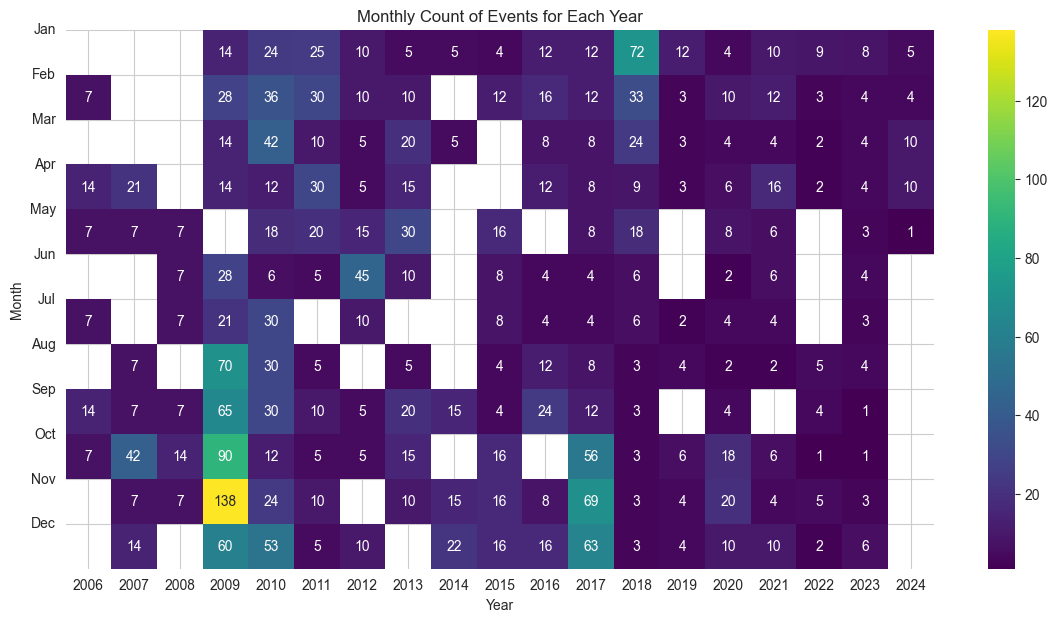

In [68]:
# Monthly Counts for Each Year

# Count the number of events per month and year
monthly_counts = df_rabies_raw.groupby(['Year', 'Month']).size().reset_index(name='Counts')

# Pivot the data for plotting
monthly_counts_pivot = monthly_counts.pivot(index='Month', columns='Year', values='Counts')

# Now plot the results
plt.figure(figsize=(14, 7))
sns.heatmap(monthly_counts_pivot, annot=True, fmt="0.0f", cmap="viridis")
plt.title('Monthly Count of Events for Each Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.yticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

From the heatmap of Monthly Count of Events for Each Year it can be seen that months October, November and December during 2009 and 2017 has a higher rate of cases. Additionaly January and February of 2018 also has higher rate of cases this is probably because of the cases at end of 2017.  

### Visualizations for 2023

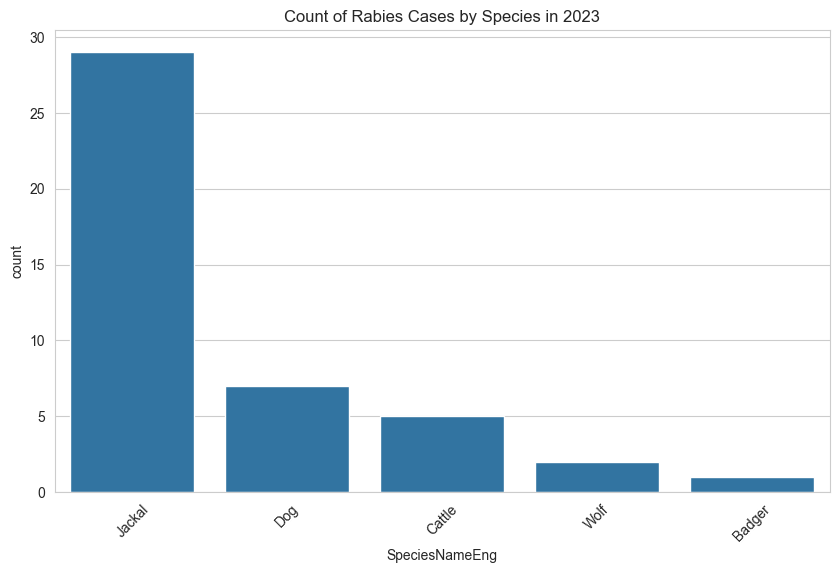

In [69]:
# Filter the DataFrame for the year 2023
df_2023 = df_rabies_raw[df_rabies_raw['Date'].dt.year == 2023]

# Count plot for Species in 2023
plt.figure(figsize=(10, 6))
sns.countplot(data=df_2023, x='SpeciesNameEng', order=df_2023['SpeciesNameEng'].value_counts().index)
plt.title('Count of Rabies Cases by Species in 2023')
plt.xticks(rotation=45)
plt.show()

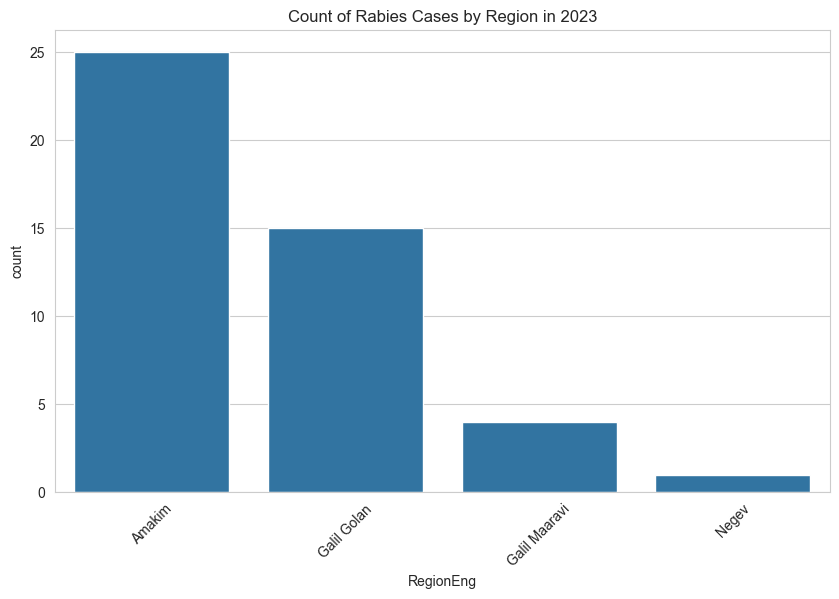

In [70]:
# Count plot for Regions in 2023
plt.figure(figsize=(10, 6))
sns.countplot(data=df_2023, x='RegionEng', order=df_2023['RegionEng'].value_counts().index)
plt.title('Count of Rabies Cases by Region in 2023')
plt.xticks(rotation=45)
plt.show()

C:\Users\DOR\AppData\Local\Temp\ipykernel_22788\3008059300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['Month'] = df_2023['Date'].dt.month  # Extract the month if not already done


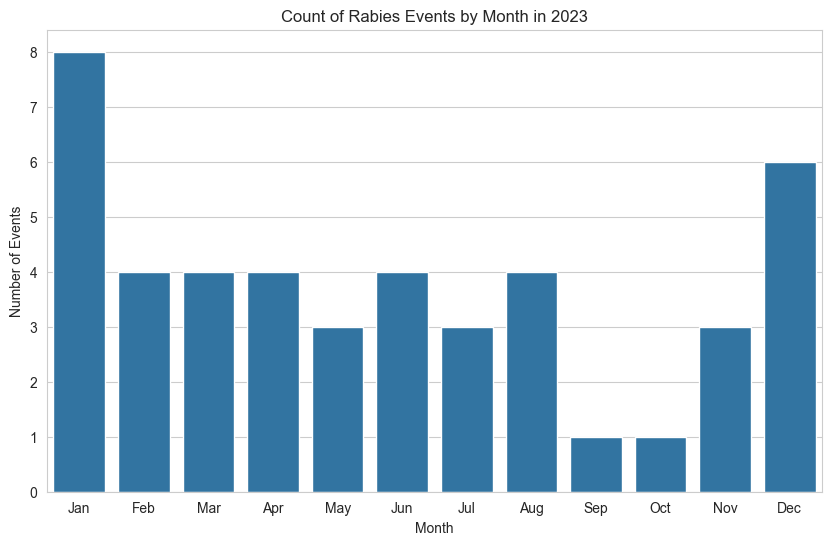

In [71]:
# Count plot for Events by Month in 2023
df_2023['Month'] = df_2023['Date'].dt.month  # Extract the month if not already done
plt.figure(figsize=(10, 6))
sns.countplot(data=df_2023, x='Month', order=range(1, 13))
plt.title('Count of Rabies Events by Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

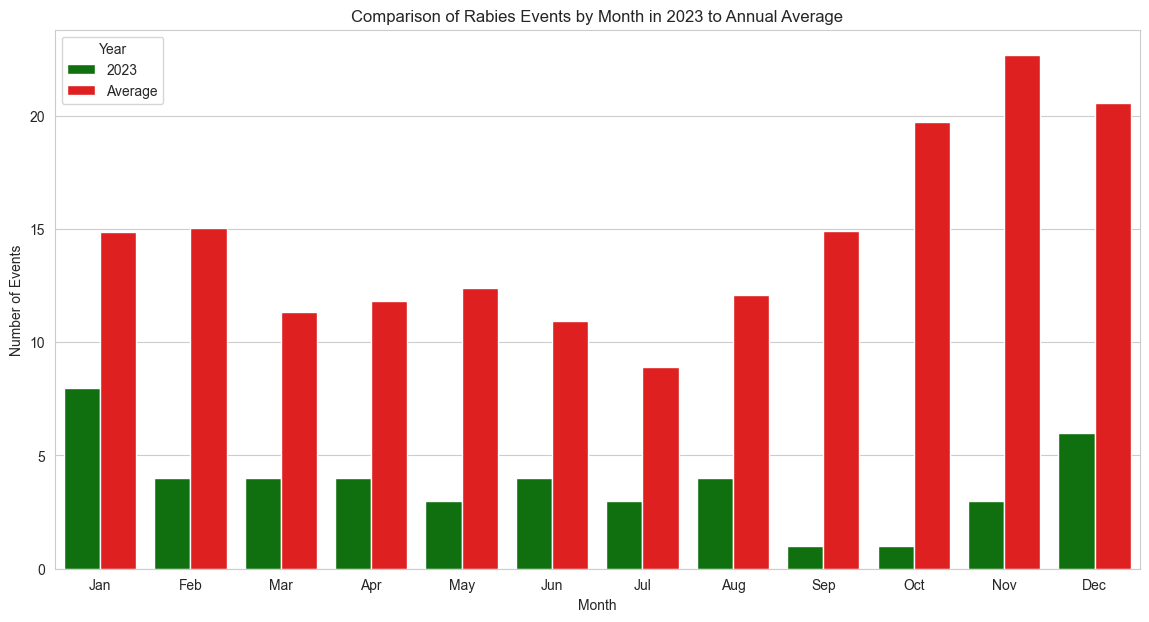

In [72]:

# Extract year and month from 'Date'
df_rabies_raw['Year'] = df_rabies_raw['Date'].dt.year
df_rabies_raw['Month'] = df_rabies_raw['Date'].dt.month

# Calculate the monthly counts for each year
monthly_counts = df_rabies_raw.groupby(['Year', 'Month']).size().reset_index(name='Counts')

# Calculate the average monthly counts across all years except 2023
average_monthly_counts = monthly_counts[monthly_counts['Year'] != 2023].groupby('Month')['Counts'].mean().reset_index(name='Counts')
average_monthly_counts['Year'] = 'Average'  # Add a column to indicate these are averages

# Filter the DataFrame for the year 2023
df_2023_counts = monthly_counts[monthly_counts['Year'] == 2023][['Month', 'Counts']]
df_2023_counts['Year'] = '2023'  # Add a column to indicate these are 2023 counts

# Combine the 2023 data with the average monthly counts
combined_df = pd.concat([df_2023_counts, average_monthly_counts])

# Convert 'Month' to a categorical type for proper ordering in the plot
combined_df['Month'] = pd.Categorical(combined_df['Month'], categories=range(1, 13), ordered=True)

# Now plot the results
plt.figure(figsize=(14, 7))

# Plot the counts with 'hue' to differentiate between 2023 and average counts
sns.barplot(data=combined_df, x='Month', y='Counts', hue='Year', palette=['green', 'red'])

plt.title('Comparison of Rabies Events by Month in 2023 to Annual Average')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.legend(title='Year')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()
